In [3]:
import numpy as np
import pandas as pd
pd.set_option('display.max_row', 40000)
pd.set_option('display.max_column', 10000)
import matplotlib.pyplot as plt
%matplotlib inline

from os.path import join

import tensorflow as tf
# tf 2.0부터 keras는 tensorflow의 공식 API
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical

import sqlite3

import glob
import os
import csv

## 초당 주행기록 가져오기
    1. %EventCode03_start - 5sec <= srcrec <= %EventCode03_end
    2. 나머지 시간의 srcrec

In [4]:
path = "res/*" #-------------------------자신의 db파일이 있는 폴더로 수정---------------------------
file_list =  glob.glob(path)
file_list_db = [file for file in file_list if file.endswith(".db")]
print ("file_list: {}".format(file_list_db))
len(file_list_db)

# EventCode03이 일어났을 당시의 초당 주행기록 가져오기
srcrec_df2 = pd.DataFrame() #연결한 db 결과 저장소
for i in range (0,len(file_list_db)):
    # event 파일 가져오기
    f = open('src/event.csv') #-------------------------자신의 event파일이 있는 폴더로 수정---------------------------
    csvReader = csv.reader(f)
    #db연결
    conn = sqlite3.connect(file_list_db[i])
    c = conn. cursor()
    # event 테이블 유무 확인 후, 있으면 제거
    c.execute('Drop Table If Exists event')
    # event 테이블 생성
    c.execute("create table event(CAR_RECDRV_KEY integer, EVENT_CODE text, EVENT_STDT text, EVENT_ENDT text)")
    # csv 파일 읽어 온 데이터 insert
    for row in csvReader:
        if row[7] == "EVENT_CODE":
            continue
        sql1 = "insert into event (CAR_RECDRV_KEY,EVENT_CODE, EVENT_STDT, EVENT_ENDT) values (?,?,?,?)"
        key= int(row[1])
        #key 추출
        if key != int(file_list_db[i][4:11]): #src에 자신의 db파일이 있어야함, 아니면 인덱스 수정할 것
            continue
        code = (row[7])
        #event 추출
        if code[-11:] != "EventCode03":
            continue
        stdt = (row[8])
        endt = (row[9])
        c.execute(sql1,(key,code,stdt,endt))
    #트랜잭션 저장
    conn.commit()
    #event03 뽐기 query 실행
    sql2 = 'SELECT SRCREC.srcValue, SRCREC.realTime, SRCREC.srcSpeed, SRCREC.srcRPM,\
    SRCREC.srcAPS, SRCREC.srcTPS, SRCREC.srcEngineLoad, SRCREC.srcIntakePress, SRCREC.srcIntakeAirTemp, ifnull(EVENT_CODE, "0") AS EVENT_CODE FROM SRCREC LEFT OUTER JOIN\
    (SELECT EVENT_CODE, EVENT_STDT s, EVENT_ENDT e FROM event\
    ) ON SRCREC.realTime BETWEEN strftime("%Y%m%d%H%M%S",s,"-6 seconds")\
     AND strftime("%Y%m%d%H%M%S",e)\
    EXCEPT \
    SELECT SRCREC.srcValue, SRCREC.realTime, SRCREC.srcSpeed, SRCREC.srcRPM,\
    SRCREC.srcAPS, SRCREC.srcTPS, SRCREC.srcEngineLoad, SRCREC.srcIntakePress, SRCREC.srcIntakeAirTemp, EVENT_CODE FROM SRCREC LEFT JOIN\
    (SELECT EVENT_CODE, EVENT_STDT s, EVENT_ENDT e FROM event\
    ) ON SRCREC.realTime BETWEEN strftime("%Y%m%d%H%M%S",s)\
     AND strftime("%Y%m%d%H%M%S",e)'
    
    query =  c.execute(sql2)
    cols = [column[0] for column in query.description]
    srcrec_df = pd.DataFrame.from_records(data=query.fetchall(), columns=cols)
    #db 파일 연결 작업
    srcrec_df2 = pd.concat([srcrec_df2, srcrec_df], ignore_index=True)
    #db 연결 종료
    c.close()
    conn.close()
    #파일 연결 종료
    f.close()
srcrec_df = srcrec_df2

file_list: ['res/2875311.db', 'res/2919551.db', 'res/2893289.db', 'res/3029691.db', 'res/2991290.db', 'res/2932228.db', 'res/3023697.db', 'res/3001050.db', 'res/2991289.db', 'res/2948773.db', 'res/2872704.db', 'res/2866021.db', 'res/2955348.db', 'res/2937846.db', 'res/3005904.db', 'res/3048682.db', 'res/3035733.db', 'res/2950322.db', 'res/2899517.db', 'res/2893129.db', 'res/2876037.db', 'res/3035500.db', 'res/2905459.db', 'res/2944918.db', 'res/2908916.db', 'res/2966874.db', 'res/2883638.db', 'res/2910252.db', 'res/2934855.db', 'res/3032866.db', 'res/2935881.db', 'res/2878804.db', 'res/3022909.db', 'res/3045704.db', 'res/2896168.db', 'res/3017527.db', 'res/2898814.db', 'res/2927496.db', 'res/2885740.db', 'res/2896736.db', 'res/2911410.db', 'res/2942697.db', 'res/2943719.db', 'res/2882362.db', 'res/2917862.db', 'res/2981366.db', 'res/3045713.db', 'res/3040795.db', 'res/2927659.db', 'res/2893294.db', 'res/3025125.db', 'res/3004464.db', 'res/3051824.db', 'res/2871081.db', 'res/2942868.db'

In [5]:
#srcrec_df

## event03이 일어난 데이터와 그 밖의 데이터 비율 1:1로 맞추기

In [6]:
# srcevent_df = srcrec_df[srcrec_df['EVENT_CODE'].str.contains('03')]
# len_srcevent = len(srcevent_df.index)
# srcnor_df = srcrec_df[srcrec_df['EVENT_CODE']=='0'].sample(len_srcevent)
# len_srcnor = len(srcnor_df.index)
# srcrec_df = pd.concat([srcevent_df,srcnor_df])
# srcrec_df

srcevent_df = srcrec_df[srcrec_df['EVENT_CODE'].str.contains('03')]
len_srcevent = len(srcevent_df.index)
srcnor_df = srcrec_df[srcrec_df['EVENT_CODE']=='0'].sample(len_srcevent)
len_srcnor = len(srcnor_df.index)
srcrec_df = pd.concat([srcevent_df,srcnor_df])
srcrec_df= srcrec_df.sort_values(by=['realTime'], axis=0,ascending=True)
#srcrec_df

## 주행기록을 x data와 y data로 나누기
* x data : 차량데이터
* y data : 이벤트 종류(%Eventcode03=1 or 나머지=0)


In [7]:
# 1번쨰 열 : event03 발생 X, 2번째 열 : event03 발생 
y_data = srcrec_df.values[:,9] # %EventCode03 , 0
y_data = pd.get_dummies(y_data).values 

y_data = y_data[:,0] 

where_0 = np.where(y_data ==0)
where_1 = np.where(y_data ==1)

y_data[where_0] = 1
y_data[where_1] = 0
y_data = to_categorical(y_data)

#y_data

In [8]:
x_data = srcrec_df.apply(pd.to_numeric, errors='coerce')
x_data = x_data.iloc[:,2:9] # srcSpeed ~ srcIntakeAirTemp
x_data = x_data.values
#x_data

## train data와 test data로 분리 ( 7 : 3 )

In [9]:
from sklearn.model_selection import train_test_split
trnx, tstx, trny, tsty = train_test_split(x_data, y_data, test_size=0.3, random_state=111)
#x_data.shape[1]

## DNN 모델 구축

In [10]:
input_shape = (x_data.shape[1], )

with tf.device('/device:GPU:0'):
    visible = layers.Input(shape=input_shape)
    hidden1 = layers.Dense(20, activation='relu')(visible)

    hidden2 = layers.Dense(20, activation='relu')(hidden1)


    hidden3= layers.Dense(20, activation='relu')(hidden2)


    hidden4 = layers.Dense(20, activation='relu')(hidden3)


    hidden5 = layers.Dense(20, activation='relu')(hidden4)


    hidden6 = layers.Dense(20, activation='relu')(hidden5)


    output = layers.Dense(2, activation='softmax')(hidden6) # 2 classification

    mip_function = models.Model(visible, output)

    mip_function.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense (Dense)                (None, 20)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_5 (Dense)              (None, 20)                420   

## 학습

In [11]:
# multi classification 용
# mip_function.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

# 2 classification 용
with tf.device('/device:GPU:0'):
    mip_function.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

    history = mip_function.fit(trnx, trny, batch_size = 40, epochs = 1000)

Epoch 1/1000
3250/3250 [==============================] - 12s 4ms/step - loss: 0.6671 - accuracy: 0.6743
Epoch 2/1000
3250/3250 [==============================] - 12s 4ms/step - loss: 0.5150 - accuracy: 0.7340
Epoch 3/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.5038 - accuracy: 0.7426
Epoch 4/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4966 - accuracy: 0.7488
Epoch 5/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4908 - accuracy: 0.7520
Epoch 6/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4888 - accuracy: 0.7513
Epoch 7/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4842 - accuracy: 0.7544
Epoch 8/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4830 - accuracy: 0.7560
Epoch 9/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4834 - accuracy: 0.7554
Epoch 10/1000
3250/3250 [==============================

3250/3250 [==============================] - 11s 4ms/step - loss: 0.4542 - accuracy: 0.7743
Epoch 79/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4527 - accuracy: 0.7768
Epoch 80/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4546 - accuracy: 0.7741
Epoch 81/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4552 - accuracy: 0.7739
Epoch 82/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4560 - accuracy: 0.7734
Epoch 83/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4535 - accuracy: 0.7748
Epoch 84/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4547 - accuracy: 0.7735
Epoch 85/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4532 - accuracy: 0.7745
Epoch 86/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4534 - accuracy: 0.7759
Epoch 87/1000
3250/3250 [==============================] - 1

3250/3250 [==============================] - 12s 4ms/step - loss: 0.4492 - accuracy: 0.7777
Epoch 155/1000
3250/3250 [==============================] - 12s 4ms/step - loss: 0.4492 - accuracy: 0.7791
Epoch 156/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4483 - accuracy: 0.7780
Epoch 157/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4493 - accuracy: 0.7773
Epoch 158/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4494 - accuracy: 0.7778
Epoch 159/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4473 - accuracy: 0.7796
Epoch 160/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4480 - accuracy: 0.7791
Epoch 161/1000
3250/3250 [==============================] - 12s 4ms/step - loss: 0.4495 - accuracy: 0.7778
Epoch 162/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4471 - accuracy: 0.7790
Epoch 163/1000
3250/3250 [==========================

3250/3250 [==============================] - 11s 4ms/step - loss: 0.4458 - accuracy: 0.7792
Epoch 231/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4462 - accuracy: 0.7804
Epoch 232/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4475 - accuracy: 0.7800
Epoch 233/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4468 - accuracy: 0.7795
Epoch 234/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4513 - accuracy: 0.7785
Epoch 235/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4530 - accuracy: 0.7778
Epoch 236/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4467 - accuracy: 0.7801
Epoch 237/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4441 - accuracy: 0.7830
Epoch 238/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4464 - accuracy: 0.7810
Epoch 239/1000
3250/3250 [==========================

3250/3250 [==============================] - 11s 3ms/step - loss: 0.4464 - accuracy: 0.7810
Epoch 307/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4481 - accuracy: 0.7799
Epoch 308/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4472 - accuracy: 0.7792
Epoch 309/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4465 - accuracy: 0.7797
Epoch 310/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4485 - accuracy: 0.7783
Epoch 311/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4490 - accuracy: 0.7805
Epoch 312/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4515 - accuracy: 0.7776
Epoch 313/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4482 - accuracy: 0.7787
Epoch 314/1000
3250/3250 [==============================] - 12s 4ms/step - loss: 0.4484 - accuracy: 0.7797
Epoch 315/1000
3250/3250 [==========================

3250/3250 [==============================] - 12s 4ms/step - loss: 0.4451 - accuracy: 0.7796
Epoch 383/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4482 - accuracy: 0.7807
Epoch 384/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4477 - accuracy: 0.7787
Epoch 385/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4471 - accuracy: 0.7789
Epoch 386/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4467 - accuracy: 0.7799
Epoch 387/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4464 - accuracy: 0.7809
Epoch 388/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4451 - accuracy: 0.7806
Epoch 389/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4454 - accuracy: 0.7801
Epoch 390/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4470 - accuracy: 0.7797
Epoch 391/1000
3250/3250 [==========================

3250/3250 [==============================] - 11s 3ms/step - loss: 0.4453 - accuracy: 0.7796
Epoch 459/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4417 - accuracy: 0.7831
Epoch 460/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4459 - accuracy: 0.7808
Epoch 461/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4449 - accuracy: 0.7804
Epoch 462/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4466 - accuracy: 0.7790
Epoch 463/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4469 - accuracy: 0.7801
Epoch 464/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4459 - accuracy: 0.7805
Epoch 465/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4415 - accuracy: 0.7842
Epoch 466/1000
3250/3250 [==============================] - 12s 4ms/step - loss: 0.4438 - accuracy: 0.7814
Epoch 467/1000
3250/3250 [==========================

3250/3250 [==============================] - 11s 3ms/step - loss: 0.4450 - accuracy: 0.7821
Epoch 535/1000
3250/3250 [==============================] - 12s 4ms/step - loss: 0.4425 - accuracy: 0.7825
Epoch 536/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4472 - accuracy: 0.7807
Epoch 537/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4465 - accuracy: 0.7798
Epoch 538/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4438 - accuracy: 0.7816
Epoch 539/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4445 - accuracy: 0.7818
Epoch 540/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4461 - accuracy: 0.7801
Epoch 541/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4439 - accuracy: 0.7817
Epoch 542/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4444 - accuracy: 0.7819
Epoch 543/1000
3250/3250 [==========================

3250/3250 [==============================] - 12s 4ms/step - loss: 0.4436 - accuracy: 0.7813
Epoch 611/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4447 - accuracy: 0.7817
Epoch 612/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4426 - accuracy: 0.7828
Epoch 613/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4440 - accuracy: 0.7794
Epoch 614/1000
3250/3250 [==============================] - 12s 4ms/step - loss: 0.4443 - accuracy: 0.7810
Epoch 615/1000
3250/3250 [==============================] - 12s 4ms/step - loss: 0.4436 - accuracy: 0.7810
Epoch 616/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4410 - accuracy: 0.7843
Epoch 617/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4422 - accuracy: 0.7827
Epoch 618/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4448 - accuracy: 0.7817
Epoch 619/1000
3250/3250 [==========================

3250/3250 [==============================] - 11s 4ms/step - loss: 0.4446 - accuracy: 0.7816
Epoch 687/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4440 - accuracy: 0.7824
Epoch 688/1000
3250/3250 [==============================] - 12s 4ms/step - loss: 0.4457 - accuracy: 0.7804
Epoch 689/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4459 - accuracy: 0.7804
Epoch 690/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4431 - accuracy: 0.7838
Epoch 691/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4423 - accuracy: 0.7822
Epoch 692/1000
3250/3250 [==============================] - 12s 4ms/step - loss: 0.4445 - accuracy: 0.7819
Epoch 693/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4440 - accuracy: 0.7806
Epoch 694/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4455 - accuracy: 0.7812
Epoch 695/1000
3250/3250 [==========================

3250/3250 [==============================] - 12s 4ms/step - loss: 0.4445 - accuracy: 0.7809
Epoch 763/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4442 - accuracy: 0.7817
Epoch 764/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4436 - accuracy: 0.7818
Epoch 765/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4419 - accuracy: 0.7824
Epoch 766/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4467 - accuracy: 0.7817
Epoch 767/1000
3250/3250 [==============================] - 12s 4ms/step - loss: 0.4396 - accuracy: 0.7842
Epoch 768/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4443 - accuracy: 0.7812
Epoch 769/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4430 - accuracy: 0.7815
Epoch 770/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4472 - accuracy: 0.7792
Epoch 771/1000
3250/3250 [==========================

3250/3250 [==============================] - 11s 4ms/step - loss: 0.4451 - accuracy: 0.7808
Epoch 839/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4449 - accuracy: 0.7812
Epoch 840/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4486 - accuracy: 0.7791
Epoch 841/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4463 - accuracy: 0.7797
Epoch 842/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4435 - accuracy: 0.7823
Epoch 843/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4480 - accuracy: 0.7784
Epoch 844/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4444 - accuracy: 0.7811
Epoch 845/1000
3250/3250 [==============================] - 12s 4ms/step - loss: 0.4464 - accuracy: 0.7811
Epoch 846/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4448 - accuracy: 0.7822
Epoch 847/1000
3250/3250 [==========================

3250/3250 [==============================] - 11s 4ms/step - loss: 0.4440 - accuracy: 0.7817
Epoch 915/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4446 - accuracy: 0.7809
Epoch 916/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4432 - accuracy: 0.7819
Epoch 917/1000
3250/3250 [==============================] - 12s 4ms/step - loss: 0.4438 - accuracy: 0.7826
Epoch 918/1000
3250/3250 [==============================] - 12s 4ms/step - loss: 0.4467 - accuracy: 0.7813
Epoch 919/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4419 - accuracy: 0.7822
Epoch 920/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4433 - accuracy: 0.7811
Epoch 921/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4452 - accuracy: 0.7806
Epoch 922/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4423 - accuracy: 0.7827
Epoch 923/1000
3250/3250 [==========================

3250/3250 [==============================] - 11s 3ms/step - loss: 0.4465 - accuracy: 0.7809
Epoch 991/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4473 - accuracy: 0.7796
Epoch 992/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4439 - accuracy: 0.7808
Epoch 993/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4442 - accuracy: 0.7813
Epoch 994/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4471 - accuracy: 0.7798
Epoch 995/1000
3250/3250 [==============================] - 12s 4ms/step - loss: 0.4428 - accuracy: 0.7823
Epoch 996/1000
3250/3250 [==============================] - 11s 4ms/step - loss: 0.4456 - accuracy: 0.7812
Epoch 997/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4459 - accuracy: 0.7818
Epoch 998/1000
3250/3250 [==============================] - 11s 3ms/step - loss: 0.4451 - accuracy: 0.7809
Epoch 999/1000
3250/3250 [==========================

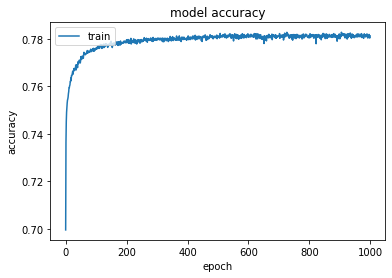

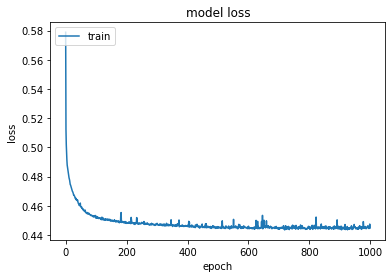

In [12]:
# # summerize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# # summerize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# test data 마지막 정확도
# test data 가장 높은 정확도
# print(np.max(history.history['val_accuracy']))

## 예측

In [13]:
evaluation = mip_function.evaluate(tstx, tsty,batch_size=32)

1741/1741 [==============================] - 4s 2ms/step - loss: 0.4542 - accuracy: 0.7772


In [14]:
# 학습된 모델인 mip_function에 test 데이터를 입력하면 model이 예측한 event03 유무가 나옵니다.
# 해당 유무를 실제 event03유무와 비교하여 
# 실제 값 = 예측 값이면 1을 아니면 0을 print합니다.
y_pred = mip_function.predict(tstx, batch_size=32)
a = 0
b = 0
c = 0
d = 0
mylist = []
for i in range(len(y_pred[:,0])) :
    if y_pred[i,0] > y_pred[i,1] : # event03 발생 X
        mylist.append(0)
        if tsty[i,1] == 0 :
            print("실제 : 0, 예측 : 0")
            a = a + 1
        else :
            print("실제 : 1, 예측 : 0")
            b=b + 1
    else :
        mylist.append(1)
        if tsty[i,1] == 1 : # event03 발생 
            print("실제 : 1, 예측 : 1")
            c=c + 1
        else :
            print("실제 : 0, 예측 : 1")
            d= d+ 1
print(a)
print(b)
print(c)
print(d)
print(len(y_pred[:,0]))

실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측

실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측

실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측

실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측

실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측

실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측

실제 : 0, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측

실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측

실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측

실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측

실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측

실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측

실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측

실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측

실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측

실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측

실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측

실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측

실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측

실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측

실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측

실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측

실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측

실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측

실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측

실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 0
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 0
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 0, 예측 : 1
실제 : 0, 예측 : 1
실제 : 1, 예측 : 1
실제 : 1, 예측

In [15]:
import json

#json파일 저장경로 설정
file_path ="./result.json" 

data = {}
data['status'] = []

for i in range(0, len(mylist)):
    data['status'].append(mylist[i])

#json형식으로 데이터 저장
with open(file_path, 'w') as outfile:
    json.dump(data, outfile)

# 저장한 파일 출력하기

with open(file_path, 'r') as f:
    json_data = json.load(f)

print(json.dumps(json_data, indent="\t") )

{
	"status": [
		1,
		1,
		1,
		1,
		0,
		0,
		1,
		0,
		1,
		0,
		0,
		0,
		0,
		0,
		0,
		0,
		1,
		1,
		1,
		0,
		0,
		0,
		0,
		1,
		0,
		1,
		1,
		1,
		1,
		1,
		1,
		1,
		1,
		0,
		1,
		1,
		1,
		0,
		0,
		1,
		1,
		0,
		0,
		0,
		0,
		1,
		1,
		1,
		1,
		1,
		0,
		1,
		0,
		1,
		1,
		1,
		1,
		1,
		1,
		0,
		1,
		0,
		1,
		1,
		1,
		1,
		1,
		0,
		1,
		1,
		1,
		0,
		1,
		1,
		1,
		1,
		1,
		1,
		1,
		0,
		0,
		1,
		0,
		0,
		0,
		1,
		1,
		0,
		0,
		1,
		1,
		1,
		0,
		0,
		1,
		0,
		0,
		1,
		0,
		1,
		1,
		1,
		0,
		1,
		1,
		0,
		1,
		1,
		0,
		0,
		0,
		1,
		1,
		1,
		1,
		1,
		0,
		1,
		1,
		1,
		0,
		1,
		0,
		0,
		1,
		1,
		0,
		1,
		0,
		1,
		1,
		0,
		0,
		1,
		1,
		1,
		0,
		1,
		1,
		0,
		1,
		1,
		0,
		0,
		1,
		0,
		0,
		0,
		1,
		1,
		0,
		1,
		0,
		1,
		1,
		0,
		1,
		1,
		1,
		0,
		1,
		0,
		0,
		1,
		1,
		1,
		1,
		1,
		0,
		1,
		0,
		1,
		0,
		1,
		1,
		1,
		0,
		0,
		1,
		0,
		1,
		0,
		1,
		1,
		1,
		0,
		0,
		1,
		1,
		1,
		1,
		1,
		1,
		1,
		0,
		1,
		1,
